In [1]:
# !pip install torch torchvision torchaudio
# !pip install matplotlib
# !pip install Pillow

# Libraries

In [2]:
import torch
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

print(torch.__version__)
print(torch.cuda.is_available())

2.5.1+cpu
False


In [3]:
import json
import cv2
import numpy as np
import os

# Isolation


In [20]:
img_path = r"C:\Users\shawn\Downloads\SMART\Radiographs\Radiographs\797.JPG"
image = Image.open(img_path)
image.show()

In [5]:
# img_path = r"C:\Users\shawn\Downloads\SMART\Segmentation\Segmentation\teeth_mask\797.JPG"
img_path = r"C:\Users\shawn\Downloads\SMART\Radiographs\Radiographs\944.JPG"
json_path = r"C:\Users\shawn\Downloads\SMART\Segmentation\Segmentation\teeth_bbox.json"

image = Image.open(img_path)
with open(json_path, 'r') as f:
    bbox_data = json.load(f)

# Get bounding boxes for .JPG
sample_entry = next(item for item in bbox_data if item["External ID"].lower() == "944.jpg")
boxes = sample_entry["Label"]["objects"]

# Draw
draw = ImageDraw.Draw(image)
for obj in boxes:
    box = obj["bounding box"]
    draw.rectangle(box, outline="red", width=2)
    draw.text((box[0], box[1]-10), obj["title"], fill="yellow")

# Show the image with boxes
image.show()
image.save(r"C:\Users\shawn\Downloads\orig_944.jpg")

In [12]:
9#IDEA? Boxes seem to be placed on the bottom left but are all bunched up together, so lets try using data augmentation to make the image a certain way. 
#note: img 748 has no teeth LOL so no boxes but this works for diff images.
# Rotating Image
img_path = r"C:\Users\shawn\Downloads\SMART\Radiographs\Radiographs\181.JPG"
image = Image.open(img_path).rotate(90, expand=True)
rotated_width, rotated_height = image.size
print(f"Rotated image size: {rotated_width} x {rotated_height}")

with open(json_path, 'r') as f:
    bbox_data = json.load(f)

entry = next(item for item in bbox_data if item["External ID"].lower() == "181.jpg")
boxes = entry["Label"]["objects"]

draw = ImageDraw.Draw(image)

for obj in boxes:
    x1, y1, x2, y2 = obj["bounding box"]
    draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
    draw.text((x1, y1 - 10), obj["title"], fill="yellow")

image.show()
image.save(r"C:\Users\shawn\Downloads\temp2.jpg")


Rotated image size: 840 x 1615


# Segmentation

In [23]:
from PIL import Image
from PIL import Image
import json
import os

img_path = r"C:\Users\shawn\Downloads\SMART\Radiographs\Radiographs\181.JPG"
bbox_json_path = r"C:\Users\shawn\Downloads\SMART\Segmentation\Segmentation\teeth_bbox.json"

output_folder = r"C:\Users\shawn\Downloads\SMART\BoundingBoxCrops\181"
os.makedirs(output_folder, exist_ok=True)

image = Image.open(img_path).rotate(-90, expand=True).convert("RGB")
image_id = os.path.basename(img_path).lower()

with open(bbox_json_path, "r") as f:
    bbox_data = json.load(f)


bbox_entry = next(item for item in bbox_data if item["External ID"].lower() == image_id)

for obj in bbox_entry["Label"]["objects"]:
    tooth_label = obj["title"]
    x1, y1, x2, y2 = map(int, obj["bounding box"])

    # Crop image using bounding box
    cropped = image.crop((x1, y1, x2, y2))

    # Only save if the crop has visible area
    if cropped.width > 10 and cropped.height > 10:
        output_path = os.path.join(output_folder, f"tooth_{tooth_label}.jpg")
        cropped.save(output_path)

print(f"Saved cropped teeth for {image_id}")



Saved cropped teeth for 944.jpg


In [25]:
from PIL import Image, ImageDraw
import json
import os

img_path = r"C:\Users\shawn\Downloads\SMART\Radiographs\Radiographs\944.JPG"
json_path = r"C:\Users\shawn\Downloads\SMART\Segmentation\Segmentation\teeth_bbox.json"

image = Image.open(img_path).rotate(-90, expand=True)
image_id = os.path.basename(img_path).lower()


with open(json_path, 'r') as f:
    bbox_data = json.load(f)

entry = next(item for item in bbox_data if item["External ID"].lower() == image_id)

draw = ImageDraw.Draw(image)
for obj in entry["Label"]["objects"]:
    box = obj["bounding box"]
    draw.rectangle(box, outline="red", width=2)
    draw.text((box[0], box[1]-10), obj["title"], fill="yellow")

image.save(r"C:\Users\shawn\Downloads\boxed_944.jpg")


In [75]:
radiograph_dir = r"C:\Users\shawn\Downloads\SMART\Radiographs\Radiographs"
bbox_json_path = r"C:\Users\shawn\Downloads\SMART\Segmentation\Segmentation\teeth_bbox.json"
output_root = r"C:\Users\shawn\Downloads\SMART\BoundingBoxCrops"
os.makedirs(output_root, exist_ok=True)

with open(bbox_json_path, 'r') as f:
    bbox_data = json.load(f)

bbox_dict = {entry["External ID"].lower(): entry["Label"]["objects"] for entry in bbox_data}

for filename in os.listdir(radiograph_dir):
    if not filename.lower().endswith(".jpg"):
        continue

    image_path = os.path.join(radiograph_dir, filename)
    image_id = filename.lower()

    if image_id not in bbox_dict:
        print(f"Skipping {image_id} (no bounding box found)")
        continue

    image = Image.open(image_path).rotate(-90, expand=True).convert("RGB")

    # Folder to save this image’s crops
    save_dir = os.path.join(output_root, os.path.splitext(filename)[0])
    os.makedirs(save_dir, exist_ok=True)

    for obj in bbox_dict[image_id]:
        tooth_label = obj["title"]
        x1, y1, x2, y2 = map(int, obj["bounding box"])

        # Crop and save
        cropped = image.crop((x1, y1, x2, y2))
        if cropped.width > 10 and cropped.height > 10:
            cropped.save(os.path.join(save_dir, f"tooth_{tooth_label}.jpg"))

    print(f"Processed: {filename}")

print("All bounding box crops saved.")

Processed: 1.JPG
Processed: 100.JPG
Processed: 1000.JPG
Processed: 1001.JPG
Processed: 1002.JPG
Processed: 1004.JPG
Processed: 1007.JPG
Processed: 1008.JPG
Processed: 1009.JPG
Processed: 101.JPG
Processed: 1010.JPG
Processed: 1011.JPG
Processed: 1012.JPG
Processed: 1013.JPG
Processed: 1014.JPG
Processed: 1015.JPG
Processed: 1016.JPG
Processed: 1017.JPG
Processed: 1018.JPG
Processed: 102.JPG
Processed: 1020.JPG
Processed: 1021.JPG
Processed: 1024.JPG
Processed: 1025.JPG
Processed: 1027.JPG
Processed: 1028.JPG
Processed: 103.JPG
Processed: 1030.JPG
Processed: 1031.JPG
Processed: 1032.JPG
Processed: 1034.JPG
Processed: 1035.JPG
Processed: 1036.JPG
Processed: 1037.JPG
Processed: 1038.JPG
Processed: 1039.JPG
Processed: 104.JPG
Processed: 1040.JPG
Processed: 1041.JPG
Processed: 1042.JPG
Processed: 1043.JPG
Processed: 1044.JPG
Processed: 1046.JPG
Processed: 1047.JPG
Processed: 105.JPG
Processed: 1051.JPG
Processed: 106.JPG
Processed: 107.JPG
Processed: 108.JPG
Processed: 109.JPG
Processed: 11

# Excel csv Image Name | Tooth #

In [49]:
import os
import csv
import re
from collections import defaultdict

cropped_root = r"C:\Users\shawn\Downloads\SMART\CroppedTeeth"
output_csv_path = r"C:\Users\shawn\Downloads\SMART\tooth_image_map.csv"

# Group teeth by image first
image_teeth_map = defaultdict(list)

for img_folder in os.listdir(cropped_root):
    full_img_path = os.path.join(cropped_root, img_folder)
    if not os.path.isdir(full_img_path):
        continue

    for file in os.listdir(full_img_path):
        match = re.search(r'tooth_(\d+)\.jpg', file)
        if match:
            tooth_num = int(match.group(1))
            image_name = f"{img_folder}.jpg"
            image_teeth_map[image_name].append(tooth_num)

# Sort tooth numbers per image
sorted_data = []
for image, teeth in image_teeth_map.items():
    for tooth in sorted(teeth):
        sorted_data.append({"Image Name": image, "Tooth#": tooth})

# Write to CSV
with open(output_csv_path, "w", newline="") as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=["Image Name", "Tooth#"])
    writer.writeheader()
    writer.writerows(sorted_data)

print("Excel:", output_csv_path)


Excel: C:\Users\shawn\Downloads\SMART\tooth_image_map.csv


# Labels

In [53]:
import json
import re
from collections import defaultdict

expert_path = r"C:\Users\shawn\Downloads\SMART\Expert\Expert\expert.json"

with open(expert_path, "r") as f:
    expert_data = json.load(f)

# Two dictionaries:
caries_labels = defaultdict(list)   # image_id -> list of carious teeth
healthy_labels = defaultdict(list)  # image_id -> list of healthy teeth

for entry in expert_data:
    desc = entry.get("Description", "").lower()
    img_id = entry.get("External ID")

    # Rule 1: Within Normal Limits → all 32 teeth are healthy
    if "within normal limits" in desc:
        healthy_labels[img_id] = list(range(1, 33))
        continue

    # Rule 2: Otherwise, any number 1–32 mentioned = caries
    # Handle ranges like "17-20"
    desc = desc.replace("–", "-").replace(" to ", "-")
    tooth_set = set()

    ranges = re.findall(r'\b(\d{1,2})\s*-\s*(\d{1,2})\b', desc)
    for start, end in ranges:
        for t in range(int(start), int(end) + 1):
            if 1 <= t <= 32:
                tooth_set.add(t)

    singles = re.findall(r'\b\d+\b', desc)
    for s in singles:
        t = int(s)
        if 1 <= t <= 32:
            tooth_set.add(t)

    if tooth_set:
        caries_labels[img_id] = sorted(tooth_set)

# === Quick test output ===
print(" Sample caries-labeled images:")
for img, teeth in list(caries_labels.items())[:5]:
    print(f"{img}: caries on teeth {teeth}")

print("\n Sample healthy-labeled images:")
for img, teeth in list(healthy_labels.items())[:5]:
    print(f"{img}: all teeth healthy")



Sample caries-labeled images:
149.JPG: caries on teeth [25, 26]
727.JPG: caries on teeth [19]
759.JPG: caries on teeth [29]
181.JPG: caries on teeth [1, 16, 30, 31]
952.JPG: caries on teeth [30]

 Sample healthy-labeled images:
53.JPG: all teeth healthy
823.JPG: all teeth healthy
85.JPG: all teeth healthy
855.JPG: all teeth healthy
117.JPG: all teeth healthy


In [58]:
import json

# Save caries-labeled teeth
with open(r"C:\Users\shawn\Downloads\SMART\caries_labels.json", "w") as f:
    json.dump(caries_labels, f, indent=4)

# Save healthy-labeled teeth
with open(r"C:\Users\shawn\Downloads\SMART\healthy_labels.json", "w") as f:
    json.dump(healthy_labels, f, indent=4)

print("Saved caries_labels.json and healthy_labels.json")

Saved caries_labels.json and healthy_labels.json


In [57]:
caries_csv_path = r"C:\Users\shawn\Downloads\SMART\caries_labels.csv"
healthy_csv_path = r"C:\Users\shawn\Downloads\SMART\healthy_labels.csv"

# === Save caries labels ===
with open(caries_csv_path, "w", newline="") as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=["Image Name", "Tooth#"])
    writer.writeheader()

    for img, teeth in caries_labels.items():
        for tooth in teeth:
            writer.writerow({"Image Name": img, "Tooth#": tooth})

with open(healthy_csv_path, "w", newline="") as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=["Image Name", "Tooth#"])
    writer.writeheader()

    for img, teeth in healthy_labels.items():
        for tooth in teeth:
            writer.writerow({"Image Name": img, "Tooth#": tooth})

print("Saved caries_labels.csv and healthy_labels.csv.")

Saved caries_labels.csv and healthy_labels.csv.


In [38]:
caries_path = r"C:\Users\shawn\Downloads\SMART\caries_labels.csv"
healthy_path = r"C:\Users\shawn\Downloads\SMART\healthy_labels.csv"

healthy_df = pd.read_csv(healthy_path)
caries_df = pd.read_csv(caries_path)

# Normalize column names
healthy_df.columns = ["Image Name", "Tooth#"]
caries_df.columns = ["Image Name", "Tooth#"]

# Add label columns
healthy_df["Label"] = 0
caries_df["Label"] = 1

# Merge both
merged_df = pd.concat([healthy_df, caries_df], ignore_index=True)

merged_df.to_csv("C:/Users/shawn/Downloads/SMART/merged_labels.csv", index=False)

In [40]:
healthy_df = pd.read_csv(r"C:\Users\shawn\Downloads\SMART\healthy_labels.csv")
caries_df = pd.read_csv(r"C:\Users\shawn\Downloads\SMART\caries_labels.csv")

# Preview original columns to make sure it's working
print("Healthy Columns:", healthy_df.columns)
print("Caries Columns:", caries_df.columns)

# Keep only Image Name and Tooth# columns (adjust column names if needed)
healthy_df = healthy_df[["Image Name", "Tooth#"]]
caries_df = caries_df[["Image Name", "Tooth#"]]

# Add labels
healthy_df["Label"] = 0
caries_df["Label"] = 1

# Merge datasets
merged_df = pd.concat([healthy_df, caries_df], ignore_index=True)

# Print counts
print("Healthy instances:", len(healthy_df))
print("Carious instances:", len(caries_df))
print("Total merged instances:", len(merged_df))

# Optional: Save result
merged_df.to_csv(r"C:\Users\shawn\Downloads\SMART\merged_labels.csv", index=False)

Healthy Columns: Index(['Image Name', 'Tooth#'], dtype='object')
Caries Columns: Index(['Image Name', 'Tooth#'], dtype='object')
✅ Healthy instances: 22432
✅ Carious instances: 418
✅ Total merged instances: 22850


In [61]:
import json
import pandas as pd
import re

# === File paths ===
expert_path = "C:/Users/shawn/Downloads/SMART/Expert/Expert/expert.json"
bbox_path = "C:/Users/shawn/Downloads/SMART/Segmentation/Segmentation/teeth_bbox.json"
output_path = "C:/Users/shawn/Downloads/SMART/tooth_labels_updated.csv"

# === Load JSONs ===
with open(expert_path, "r") as f:
    expert_data = json.load(f)

with open(bbox_path, "r") as f:
    bbox_data = json.load(f)

# === Map of image name → set of existing teeth ===
present_teeth = {}
for entry in bbox_data:
    img_id = entry.get("External ID", "").lower()
    objects = entry.get("Label", {}).get("objects", [])
    teeth = [int(obj["title"]) for obj in objects if obj["title"].isdigit()]
    if teeth:
        present_teeth[img_id] = set(teeth)

# === Parse expert descriptions ===
records = []

for entry in expert_data:
    img_id = entry.get("External ID", "").lower()
    desc = entry.get("Description", "").lower()

    if not img_id or img_id not in present_teeth:
        continue  # skip if no teeth info

    existing_teeth = present_teeth[img_id]
    carious_teeth = set()

    if "within normal limits" in desc:
        for t in existing_teeth:
            records.append({"Image Name": img_id, "Tooth#": t, "Label": 0})
        continue

    # Parse ranges and singles
    desc = desc.replace("–", "-").replace(" to ", "-")
    ranges = re.findall(r'\b(\d{1,2})\s*-\s*(\d{1,2})\b', desc)
    for start, end in ranges:
        carious_teeth.update(range(int(start), int(end) + 1))

    singles = re.findall(r'\b\d+\b', desc)
    for s in singles:
        t = int(s)
        if 1 <= t <= 32:
            carious_teeth.add(t)

    # Assign labels
    for t in existing_teeth:
        label = 1 if t in carious_teeth else 0
        records.append({"Image Name": img_id, "Tooth#": t, "Label": label})

# === Save to CSV ===
df = pd.DataFrame(records)
df.to_csv(output_path, index=False)
print(f"✅ Saved {len(df)} labeled teeth to: {output_path}")


✅ Saved 25259 labeled teeth to: C:/Users/shawn/Downloads/SMART/tooth_labels_updated.csv


In [62]:
import pandas as pd

# Load your labeled CSV
df = pd.read_csv("C:/Users/shawn/Downloads/SMART/tooth_labels_updated.csv")

# Count healthy (0) vs carious (1)
label_counts = df['Label'].value_counts().sort_index()

print("Label Counts:")
print(f"Healthy (0):  {label_counts.get(0, 0)}")
print(f"Carious (1):  {label_counts.get(1, 0)}")


Label Counts:
Healthy (0):  24873
Carious (1):  386


# EDA

In [33]:
import os
import json
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

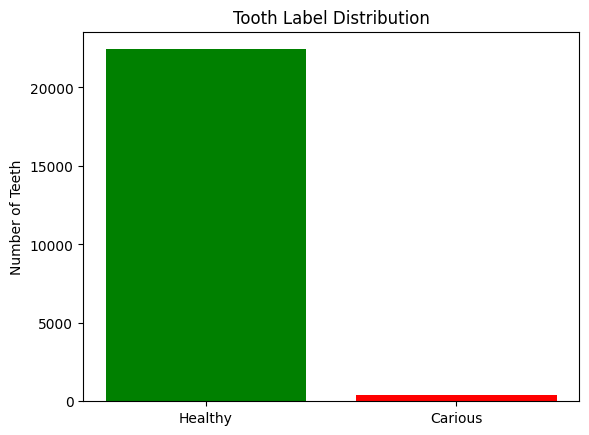

In [55]:
caries_path = r"C:\Users\shawn\Downloads\SMART\caries_labels.json"
with open(caries_path, "r") as f:
    caries_labels = json.load(f)
#CHECK ON THE #S
healthy_path = r"C:\Users\shawn\Downloads\SMART\healthy_labels.json"
with open(healthy_path, "r") as f:
    healthy_labels = json.load(f)

n_caries = sum(len(teeth) for teeth in caries_labels.values())
n_healthy = sum(len(teeth) for teeth in healthy_labels.values())

labels = ["Healthy", "Carious"]
counts = [n_healthy, n_caries]

plt.bar(labels, counts, color=["green", "red"])
plt.title("Tooth Label Distribution")
plt.ylabel("Number of Teeth")
plt.show()


In [6]:
   # !pip install -U matplotlib 
#fixed kernel dying temp fix

In [53]:
# Flatten all carious teeth into a single list
carious_teeth = []
for img, teeth in caries_labels.items():
    for tooth in teeth:
        carious_teeth.append(tooth)

# Count
caries_count = Counter(carious_teeth)

# Print counts
for t in range(1, 33):
    print(f"Tooth {t}: {caries_count.get(t, 0)} caries cases")

Tooth 1: 23 caries cases
Tooth 2: 15 caries cases
Tooth 3: 9 caries cases
Tooth 4: 11 caries cases
Tooth 5: 4 caries cases
Tooth 6: 7 caries cases
Tooth 7: 5 caries cases
Tooth 8: 5 caries cases
Tooth 9: 8 caries cases
Tooth 10: 9 caries cases
Tooth 11: 12 caries cases
Tooth 12: 6 caries cases
Tooth 13: 15 caries cases
Tooth 14: 13 caries cases
Tooth 15: 22 caries cases
Tooth 16: 19 caries cases
Tooth 17: 14 caries cases
Tooth 18: 23 caries cases
Tooth 19: 37 caries cases
Tooth 20: 12 caries cases
Tooth 21: 11 caries cases
Tooth 22: 5 caries cases
Tooth 23: 4 caries cases
Tooth 24: 2 caries cases
Tooth 25: 4 caries cases
Tooth 26: 8 caries cases
Tooth 27: 9 caries cases
Tooth 28: 7 caries cases
Tooth 29: 12 caries cases
Tooth 30: 36 caries cases
Tooth 31: 33 caries cases
Tooth 32: 18 caries cases


In [34]:
# Flatten all carious teeth into a single list
healthy_teeth = []
for img, teeth in healthy_labels.items():
    for tooth in teeth:
        healthy_teeth.append(tooth)

# Count
healthy_count = Counter(healthy_teeth)

# Print counts
for t in range(1, 33):
    print(f"Tooth {t}: {healthy_count.get(t, 0)} healthy cases")

Tooth 1: 701 healthy cases
Tooth 2: 701 healthy cases
Tooth 3: 701 healthy cases
Tooth 4: 701 healthy cases
Tooth 5: 701 healthy cases
Tooth 6: 701 healthy cases
Tooth 7: 701 healthy cases
Tooth 8: 701 healthy cases
Tooth 9: 701 healthy cases
Tooth 10: 701 healthy cases
Tooth 11: 701 healthy cases
Tooth 12: 701 healthy cases
Tooth 13: 701 healthy cases
Tooth 14: 701 healthy cases
Tooth 15: 701 healthy cases
Tooth 16: 701 healthy cases
Tooth 17: 701 healthy cases
Tooth 18: 701 healthy cases
Tooth 19: 701 healthy cases
Tooth 20: 701 healthy cases
Tooth 21: 701 healthy cases
Tooth 22: 701 healthy cases
Tooth 23: 701 healthy cases
Tooth 24: 701 healthy cases
Tooth 25: 701 healthy cases
Tooth 26: 701 healthy cases
Tooth 27: 701 healthy cases
Tooth 28: 701 healthy cases
Tooth 29: 701 healthy cases
Tooth 30: 701 healthy cases
Tooth 31: 701 healthy cases
Tooth 32: 701 healthy cases


In [57]:
print("Number of images:", len(healthy_labels))
for i, (img, teeth) in enumerate(healthy_labels.items()):
    print(f"{img}: {teeth}")
    if i >= 4:
        break

Number of images: 701
53.jpg: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
823.jpg: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
85.jpg: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
855.jpg: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
117.jpg: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]


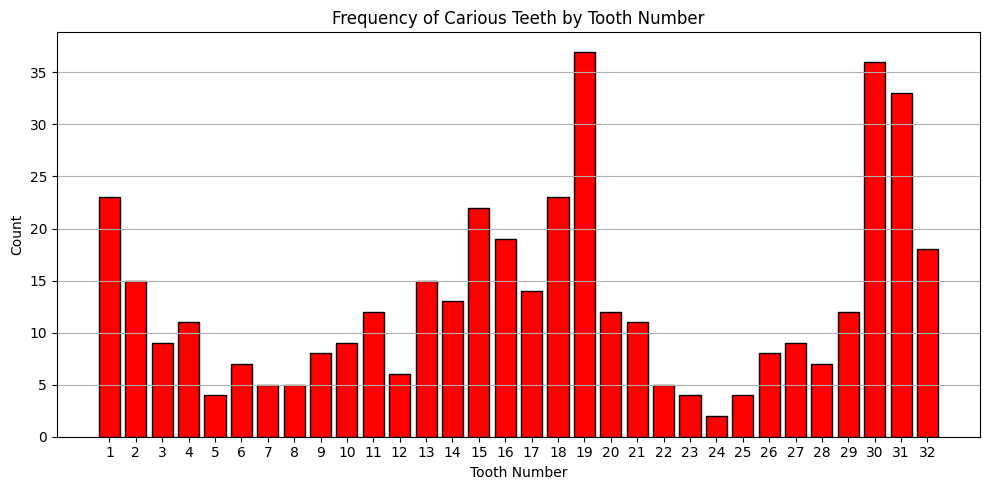

In [30]:
carious_teeth = []

# Flatten all tooth numbers from all images
for teeth in caries_labels.values():
    carious_teeth.extend(teeth)

# Count each individual tooth
caries_count = Counter(carious_teeth)

# Ensure all teeth (1–32) are shown
tooth_nums = list(range(1, 33))
counts = [caries_count.get(t, 0) for t in tooth_nums]

plt.figure(figsize=(10, 5))
plt.bar(tooth_nums, counts, color='red', edgecolor='black')
plt.title("Frequency of Carious Teeth by Tooth Number")
plt.xlabel("Tooth Number")
plt.ylabel("Count")
plt.xticks(tooth_nums)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

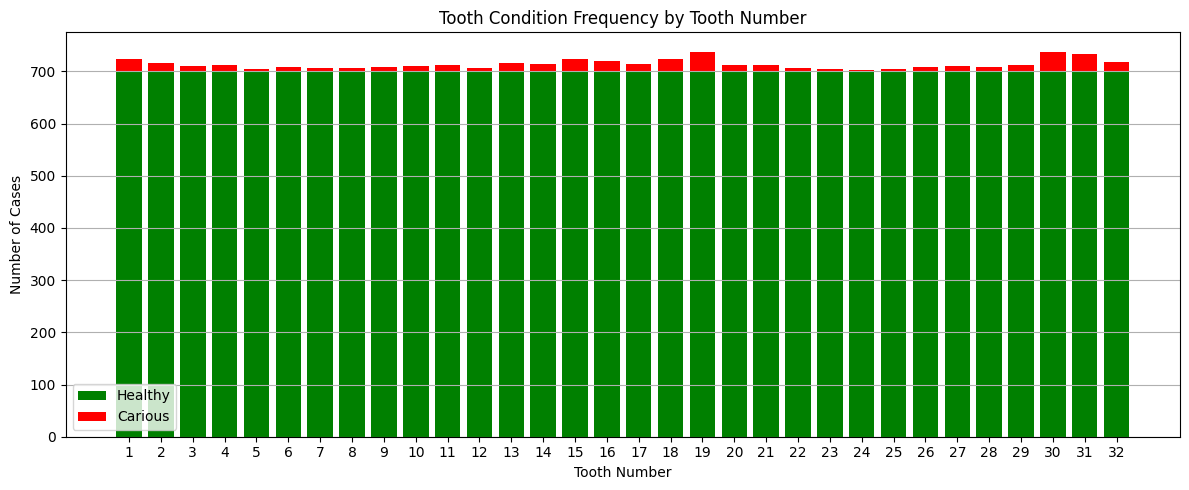

In [51]:
healthy_teeth = [t for teeth in healthy_labels.values() for t in teeth]

healthy_count = Counter(healthy_teeth)

# Generate counts for all 32 teeth
tooth_nums = list(range(1, 33))
healthy_vals = [healthy_count.get(t, 0) for t in tooth_nums]

# Plot stacked bar chart
plt.figure(figsize=(12, 5))
plt.bar(tooth_nums, healthy_vals, label="Healthy", color="green")
plt.bar(tooth_nums, caries_vals, bottom=healthy_vals, label="Carious", color="red")
plt.title("Tooth Condition Frequency by Tooth Number")
plt.xlabel("Tooth Number")
plt.ylabel("Number of Cases")
plt.xticks(tooth_nums)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

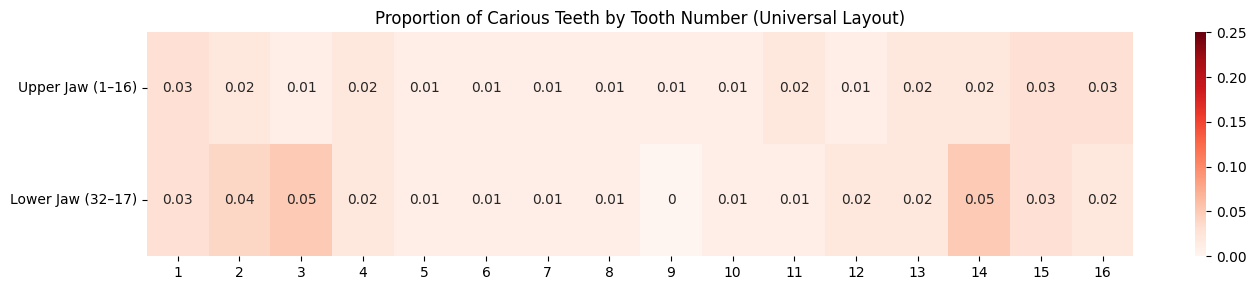

In [56]:
with open(caries_path, "r") as f:
    caries_labels = json.load(f)
caries_labels = {k.lower(): [int(x) for x in v] for k, v in caries_labels.items()}

with open(healthy_path, "r") as f:
    healthy_labels = json.load(f)
healthy_labels = {k.lower(): [int(x) for x in v] for k, v in healthy_labels.items()}

# Count caries and healthy by tooth number
healthy_counts = Counter(t for teeth in healthy_labels.values() for t in teeth)
carious_counts = Counter(t for teeth in caries_labels.values() for t in teeth)

# Calculate proportion of carious cases per tooth
tooth_props = {}
for t in range(1, 33):
    total = healthy_counts.get(t, 0) + carious_counts.get(t, 0)
    prop = carious_counts.get(t, 0) / total if total > 0 else np.nan
    tooth_props[t] = round(prop, 2)

# Reorder for 2x16 layout: top = 1–16, bottom = 32–17 (reversed)
heatmap_matrix_reordered = np.array([
    [tooth_props.get(i, np.nan) for i in range(1, 17)],
    [tooth_props.get(i, np.nan) for i in range(32, 16, -1)]
])

# Plot heatmap
plt.figure(figsize=(14, 3))
sns.heatmap(
    heatmap_matrix_reordered,
    annot=True,
    cmap="Reds",
    vmin=0,
    vmax=0.25,  # Updated scale
    xticklabels=list(range(1, 17)),
    yticklabels=["Upper Jaw (1–16)", "Lower Jaw (32–17)"]
)
plt.title("Proportion of Carious Teeth by Tooth Number (Universal Layout)")
plt.tight_layout()
plt.show()

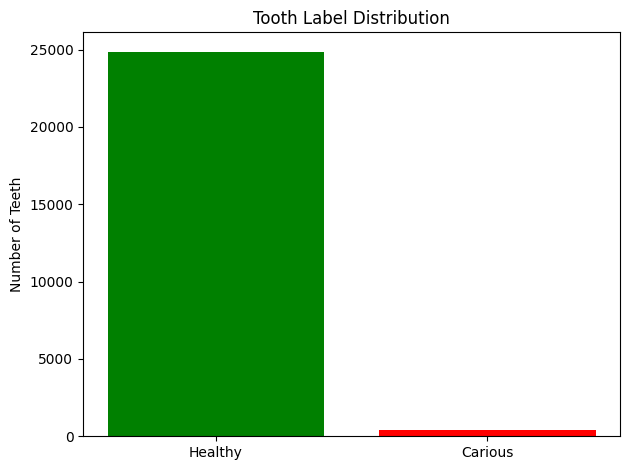

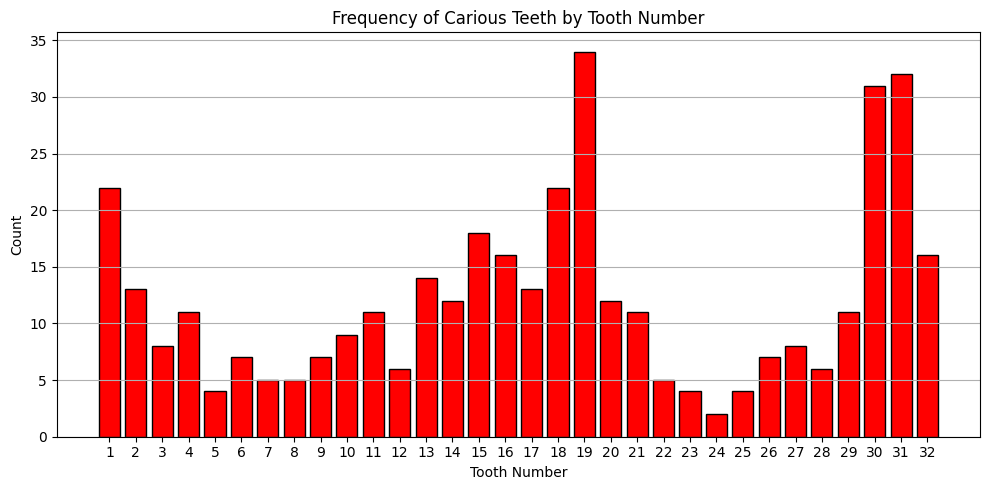

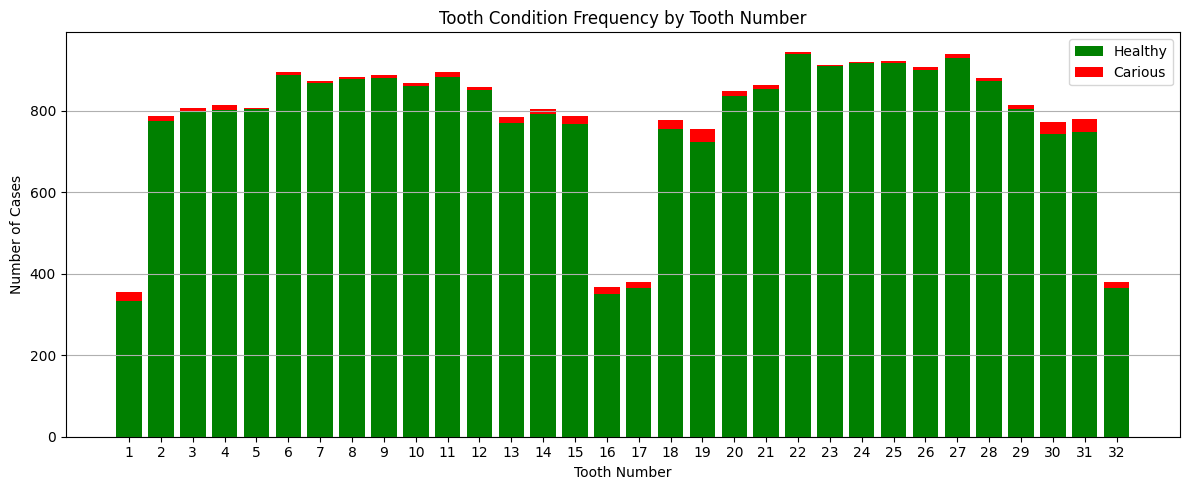

<Figure size 640x480 with 0 Axes>

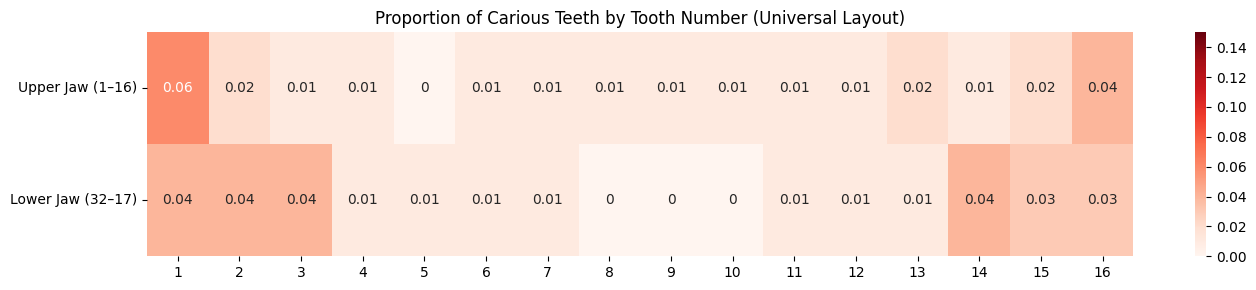

<Figure size 640x480 with 0 Axes>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter

# === Load the labeled CSV ===
csv_path = r"C:\Users\shawn\Downloads\SMART\tooth_labels_updated.csv"
df = pd.read_csv(csv_path)

# === 1. Bar Plot: Total Label Counts ===
label_counts = df['Label'].value_counts().sort_index()
labels = ['Healthy', 'Carious']
counts = [label_counts.get(0, 0), label_counts.get(1, 0)]

plt.bar(labels, counts, color=["green", "red"])
plt.title("Tooth Label Distribution")
plt.ylabel("Number of Teeth")
plt.tight_layout()
plt.show()

# === 2. Bar Plot: Frequency of Carious Teeth by Tooth Number ===
carious_teeth = df[df['Label'] == 1]['Tooth#'].tolist()
caries_count = Counter(carious_teeth)
tooth_nums = list(range(1, 33))
caries_vals = [caries_count.get(t, 0) for t in tooth_nums]

plt.figure(figsize=(10, 5))
plt.bar(tooth_nums, caries_vals, color='red', edgecolor='black')
plt.title("Frequency of Carious Teeth by Tooth Number")
plt.xlabel("Tooth Number")
plt.ylabel("Count")
plt.xticks(tooth_nums)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# === 3. Stacked Bar Chart: Healthy + Carious by Tooth Number ===
healthy_teeth = df[df['Label'] == 0]['Tooth#'].tolist()
healthy_count = Counter(healthy_teeth)
healthy_vals = [healthy_count.get(t, 0) for t in tooth_nums]

plt.figure(figsize=(12, 5))
plt.bar(tooth_nums, healthy_vals, label="Healthy", color="green")
plt.bar(tooth_nums, caries_vals, bottom=healthy_vals, label="Carious", color="red")
plt.title("Tooth Condition Frequency by Tooth Number")
plt.xlabel("Tooth Number")
plt.ylabel("Number of Cases")
plt.xticks(tooth_nums)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()
plt.savefig('dist.png')
# === 4. Heatmap: Proportion of Carious Teeth by Tooth Number ===
# Calculate proportion of caries for each tooth
tooth_props = {}
for t in tooth_nums:
    total = healthy_count.get(t, 0) + caries_count.get(t, 0)
    prop = caries_count.get(t, 0) / total if total > 0 else np.nan
    tooth_props[t] = round(prop, 2)

# Reshape for dental layout (top: 1–16, bottom: 32–17)
heatmap_matrix_reordered = np.array([
    [tooth_props.get(i, np.nan) for i in range(1, 17)],
    [tooth_props.get(i, np.nan) for i in range(32, 16, -1)]
])

plt.figure(figsize=(14, 3))
sns.heatmap(
    heatmap_matrix_reordered,
    annot=True,
    cmap="Reds",
    vmin=0,
    vmax=0.15,
    xticklabels=list(range(1, 17)),
    yticklabels=["Upper Jaw (1–16)", "Lower Jaw (32–17)"]
)
plt.title("Proportion of Carious Teeth by Tooth Number (Universal Layout)")
plt.tight_layout()
plt.show()
plt.savefig('heat.png')